In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# On charge les données dans un dataframe "df"
df = pd.read_csv('../data/raw/terrorisme_sahel.csv')


############################################################
## FILTRES SUR LES COLONNES

# On récupère ici seulement les évènements qui nous intéressent, ceux liés à des violences politiques
events_filter = ['Battles', 'Explosions/Remote violence', 'Violence against civilians', 'Strategic developments']
df = df[df['event_type'].isin(events_filter)]

# On réinitialise l'index
df = df.reset_index(drop=True)


############################################################
## TRANSFORMATION DES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])


############################################################
## CREATION DE NOUVELLES COLONNES

# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))


##
# On ajoute des colonnes "actor1_type" et "actor2 _type" qui permettent d'avoir le nom de la catégorie d'acteur

# Ce dictionnaire associe les valeurs des colonnes "inter1" et "inter2"
# au nom de chaque catégorie d'acteur (source : codebook ACLED)
actor_type = {
    1: "State Forces",
    2: "Rebel Groups",
    3: "Political Militias",
    4: "Identity Militias",
    5: "Rioters",
    6: "Protesters",
    7: "Civilians",
    8: "External/Other Forces",
}

# On ajoute les colonnes "actor1_type" et "actor2_type" au dataframe
df['actor1_type'] = df['inter1'].map(actor_type)
df['actor2_type'] = df['inter2'].map(actor_type)


##
# On ajoute une colonne "interaction_type" qui permet d'avoir le nom du type d'interaction entre 2 acteurs

# On crée un dictionnaire associant aux valeurs de la colonne "interaction"
# les 2 acteurs impliqués dans une confrontation (source : codebook ACLED)
interaction_type = {
    10: 'SOLE STATE FORCES ACTION',
    11: 'STATE FORCES VERSUS STATE FORCES',
    12: 'STATE FORCES VERSUS REBELS',
    13: 'STATE FORCES VERSUS POLITICAL MILITIA',
    14: 'STATE FORCES VERSUS IDENTITY MILITIA',
    15: 'STATE FORCES VERSUS RIOTERS',
    16: 'STATE FORCES VERSUS PROTESTERS',
    17: 'STATE FORCES VERSUS CIVILIANS',
    18: 'STATE FORCES VERSUS EXTERNAL/OTHER FORCES',
    20: 'SOLE REBEL ACTION',
    22: 'REBELS VERSUS REBELS',
    23: 'REBELS VERSUS POLITICAL MILITIA',
    24: 'REBELS VERSUS IDENTITY MILITIA',
    25: 'REBELS VERSUS RIOTERS',
    26: 'REBELS VERSUS PROTESTERS',
    27: 'REBELS VERSUS CIVILIANS',
    28: 'REBELS VERSUS OTHERS',
    30: 'SOLE POLITICAL MILITIA ACTION',
    33: 'POLITICAL MILITIA VERSUS POLITICAL MILITIA',
    34: 'POLITICAL MILITIA VERSUS IDENTITY MILITIA',
    35: 'POLITICAL MILITIA VERSUS RIOTERS',
    36: 'POLITICAL MILITIA VERSUS PROTESTERS',
    37: 'POLITICAL MILITIA VERSUS CIVILIANS',
    38: 'POLITICAL MILITIA VERSUS OTHERS',
    40: 'SOLE IDENTITY MILITIA ACTION',
    44: 'IDENTITY MILITIA VERSUS IDENTITY MILITIA',
    45: 'IDENTITY MILITIA VERSUS RIOTERS',
    46: 'IDENTITY MILITIA VERSUS PROTESTERS',
    47: 'IDENTITY MILITIA VERSUS CIVILIANS',
    48: 'IDENTITY MILITIA VERSUS OTHER',
    50: 'SOLE RIOTER ACTION',
    55: 'RIOTERS VERSUS RIOTERS',
    56: 'RIOTERS VERSUS PROTESTERS',
    57: 'RIOTERS VERSUS CIVILIANS',
    58: 'RIOTERS VERSUS OTHERS',
    60: 'SOLE PROTESTER ACTION',
    66: 'PROTESTERS VERSUS PROTESTERS',
    67: 'PROTESTERS VERSUS CIVILIANS',
    68: 'PROTESTERS VERSUS OTHER',
    70: 'SOLE CIVILIAN ACTION',
    77: 'CIVILIANS VERSUS CIVILIANS',
    78: 'OTHER ACTOR VERSUS CIVILIANS',
    80: 'SOLE OTHER ACTION',
    88: 'OTHER VERSUS OTHER'
}

# On ajoute une colonne "interaction_type" au dataframe
df['interaction_type'] = df['interaction'].map(interaction_type)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une organisation terroriste

# On crée une liste contenant les organisations terroristes
terrorist_groups = ['Ansaroul Islam',
                       'AQIM: Al Qaeda in the Islamic Maghreb',
                       'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (Sahel)',
                       'Islamic State (West Africa)',
                       'Islamic State (West Africa) - Lake Chad Faction',
                       'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'JNIM: Group for Support of Islam and Muslims',
                       'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)',
                       'Katiba Gourma',
                       'Katiba Macina',
                       'Katiba Serma']

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# On ajoute la colonne "is_terrorist_group_related" au dataframe
df['is_terrorist_group_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une pmc russe
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# On ajoute la colonne "is_pmc_related" au dataframe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)


##
# On crée une nouvelle colonne 'terrorist_group_filiation' qui permet d'associer chaque organisation terroriste
# à son organisation mère

# On crée d'abord un dictionnaire d'association entre organisation terroriste et organisation mère
terrorist_group_filiation = {
    'Ansaroul Islam': 'Al Qaida',
    'AQIM: Al Qaeda in the Islamic Maghreb': 'Al Qaida',
    'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (Sahel)' : 'Etat Islamique',
    'Islamic State (West Africa)': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'JNIM: Group for Support of Islam and Muslims': 'Al Qaida',
    'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)': 'Al Qaida',
    'Katiba Gourma': 'Al Qaida',
    'Katiba Macina': 'Al Qaida',
    'Katiba Serma': 'Al Qaida'
}

# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
def map_filiation(row):
    for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
        if row[actor] in terrorist_group_filiation:
            return terrorist_group_filiation[row[actor]]
    return "Aucune"

# On ajoute la colonne "terrorist_group_filiation" au dataframe
df['terrorist_group_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## SUPPRESSION DES COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor2',
    'assoc_actor_2',
    'inter1',
    'inter2',
    'interaction',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'event_id_cnty'
]

df = df.drop(columns=columns_to_drop, axis=1)



## RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       754
           1       0.96      1.00      0.98      2057

    accuracy                           0.96      2811
   macro avg       0.97      0.94      0.95      2811
weighted avg       0.97      0.96      0.96      2811


## REPARTITION CLASSE CIBLE
 is_terrorist_group_related
1    10297
0     3757
Name: count, dtype: int64

## AUC-ROC
Score : 0.9825229629304865


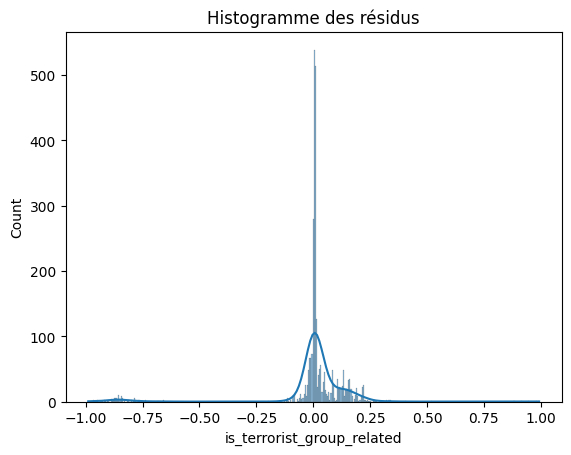


## VALIDATION CROISEE
AUC-ROC scores for each fold: [0.98016302 0.97796149 0.96884491 0.97935781 0.97767799]
Mean AUC-ROC: 0.9768010425585191
Standard Deviation: 0.004080580765690026


In [2]:
############################################################
## TESTS DE LINEARITE

##
# On entraîne d'abord un modèle de régression logistique pour tester la linéarité des relations

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score

# Séparation des caractéristiques et de la cible
X = df.drop(columns=['event_date', 'is_terrorist_group_related', 'terrorist_group_filiation'], axis=1)
y = df['is_terrorist_group_related']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hot One Encoding des variables catégorielles après le split
cat_columns = ['event_type', 'country', 'admin1', 'actor1_type', 'actor2_type', 'interaction_type']
X_train_encoded = pd.get_dummies(X_train, columns=cat_columns, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=cat_columns, dtype=int)
# On aligne les colonnes de X_test_encoded sur celles de X_train_encoded
# pour s'assurer qu'ils ont les mêmes colonnes
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Entraînement du modèle de régression logistique
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_encoded, y_train)

# Évaluation du modèle
y_pred = logreg.predict(X_test_encoded)
print("\n## RAPPORT DE CLASSIFICATION")
print(classification_report(y_test, y_pred))
# On observe que les métriques d'évaluation qu'on obtient sont plausibles et réalistes
# excepté la valeur parfaite pour le recall sur la classe 1 et la précision sur la classe 0.

# On peut ensuite calculer la répartition entre les 2 classes de notre variable cible
class_counts = df['is_terrorist_group_related'].value_counts()
print("\n## REPARTITION CLASSE CIBLE\n", class_counts)
# La répartition est de 30% pour la classe 0 et 70% pour la classe 1, on peut considérer que les classes
# sont modérément déséquilibrées. Dans le cadre de notre sujet, cela correspond à la réalité qu'on peut observer,
# on ne va donc pas effectuer de rééquilibrage de classe.

# Comme les classes sont déséquilibrées, on va utiliser la métrique AUC-ROC qui contrairement
# à l'accuracy, prend en compte les vrais positifs et les faux positifs, offrant une image
# plus précise de la performance du modèle
y_pred_prob = logreg.predict_proba(X_test_encoded)[:, 1]
print("\n## AUC-ROC")
print("Score :", roc_auc_score(y_test, y_pred_prob))
# Le score de 0.98 obtenu indique que le modèle de régression logistique a une excellente capacité
# de discrimination entre les classes 0 et 1.

# Ensuite on peut examiner les résidus pour vérifier les écarts par rapport à la linéarité
res = y_test - y_pred_prob

sns.histplot(res, kde=True)
plt.title('Histogramme des résidus')
plt.show()
# On remarque que les points ne sont pas répartis uniformément autour de zéro sur l'axe des valeurs prédites,
# l'homoscédasticité n'est donc pas respectée.
# On remarque également une forme en cloche dans les résidus, ce qui peut indiquer un problème de linéarité.
# Enfin on remarque que certaines valeurs sont très éloignées de 0, ce qui indique la présence d'outliers.
# Pour ces 3 raisons, on peut en conclure que notre modèle de régression logistique n'est pas linéaire.

# On peut ensuite utiliser une validation croisée pour évaluer la performance du modèle
# sur plusieurs sous-ensembles de données afin d'identifier s'il y a du surapprentissage
from sklearn.model_selection import cross_val_score

# On utilise un StratifiedKFold pour effectuer une validation croisée stratifiée
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# On utilise le ROC-AUC comme méthode de scoring
scores = cross_val_score(logreg, X_train_encoded, y_train, cv=stratified_kfold, scoring='roc_auc')
print("\n## VALIDATION CROISEE")
print(f'AUC-ROC scores for each fold: {scores}')
print(f'Mean AUC-ROC: {scores.mean()}')
print(f'Standard Deviation: {scores.std()}')
# Les scores obtenus semblent cohérents entre les différentes folds, avec une variance très faible,
# ce qui indique que le modèle de régression logistique est robuste et fiable.

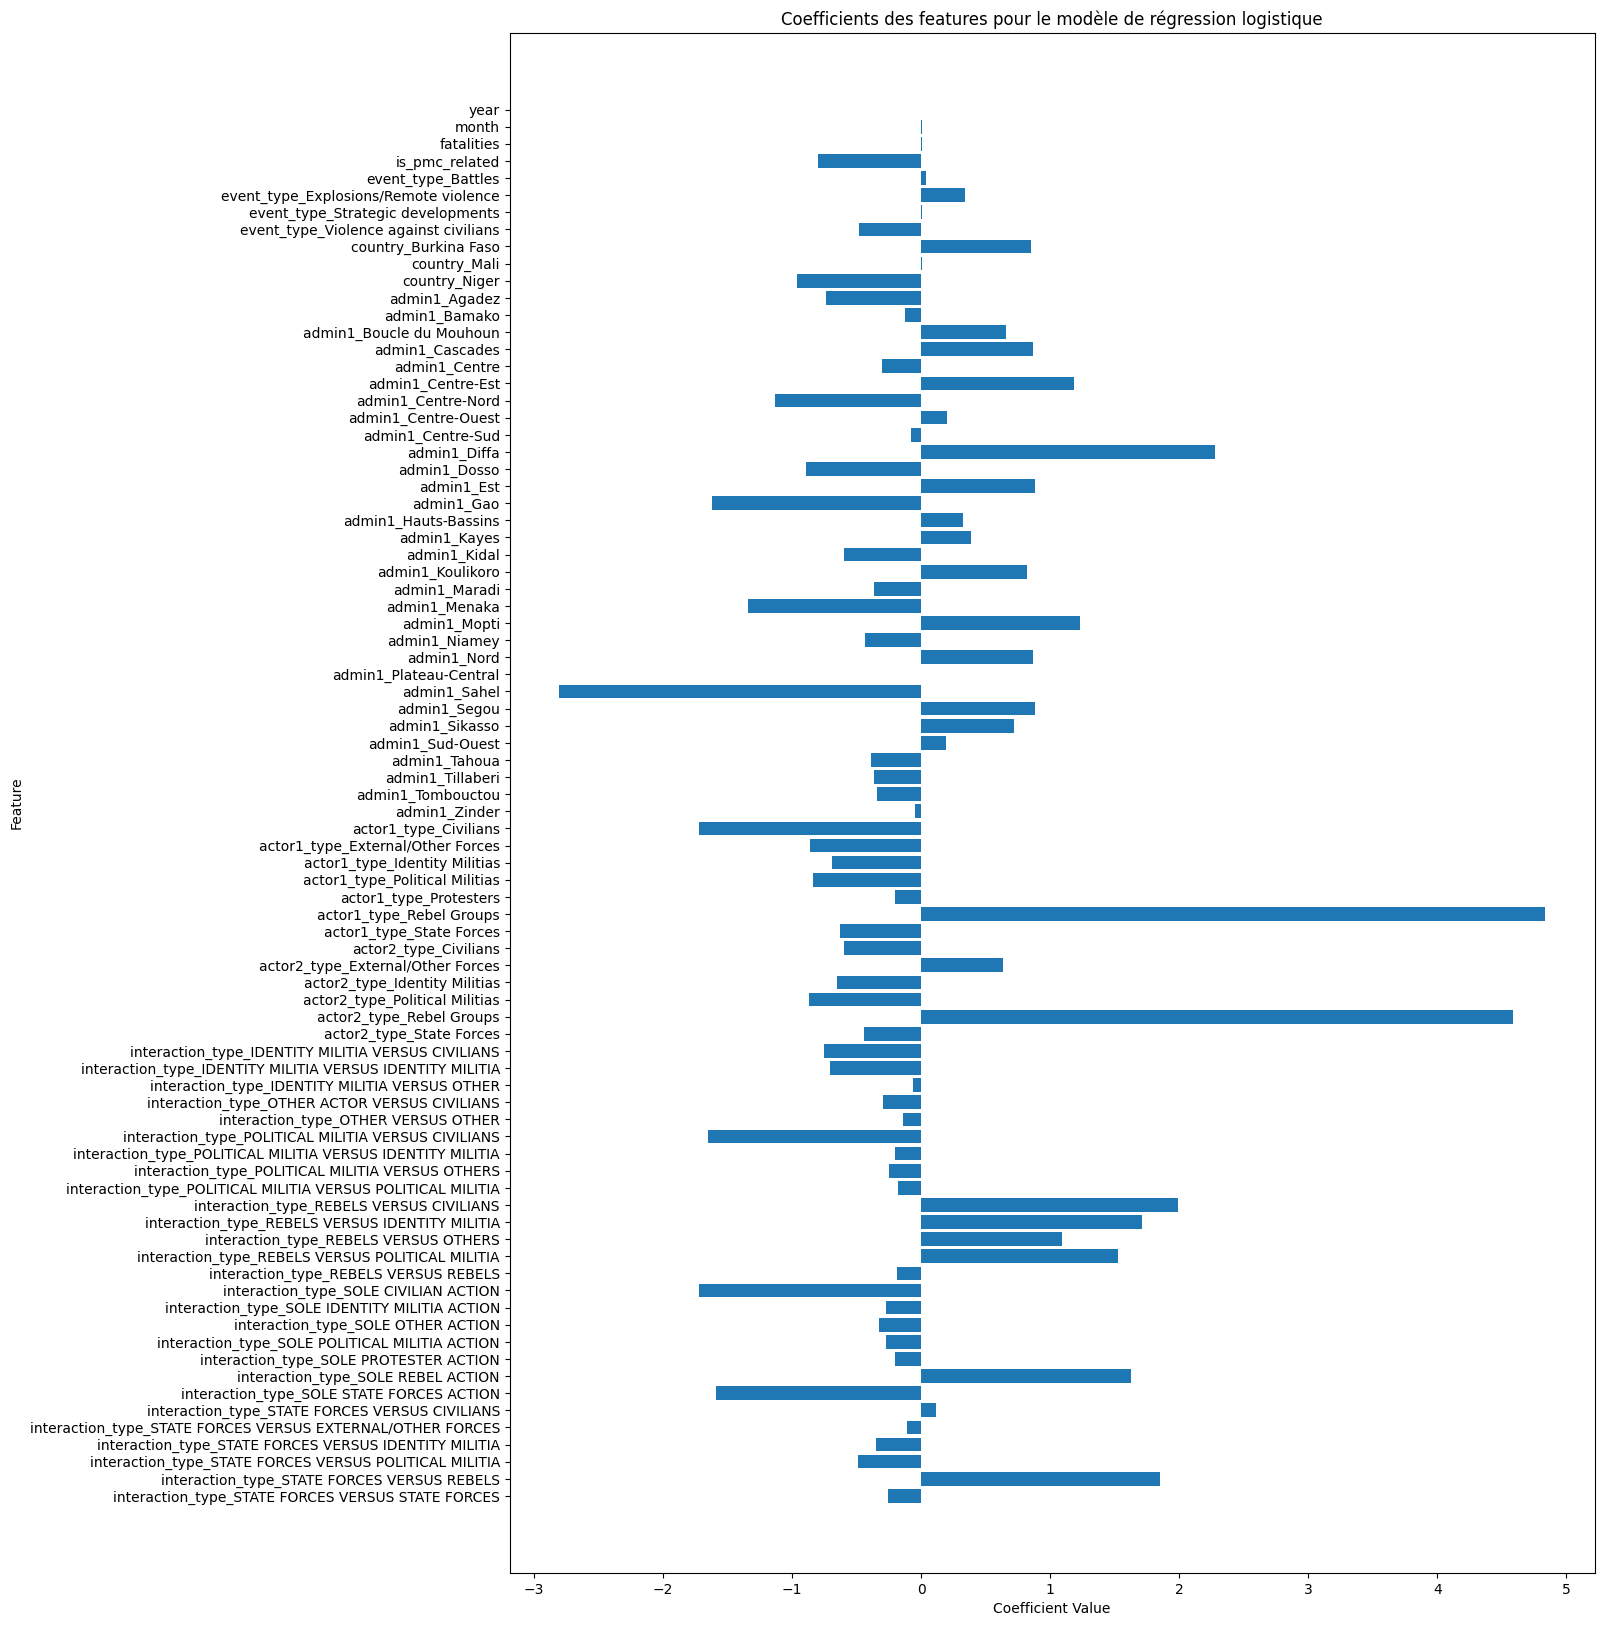

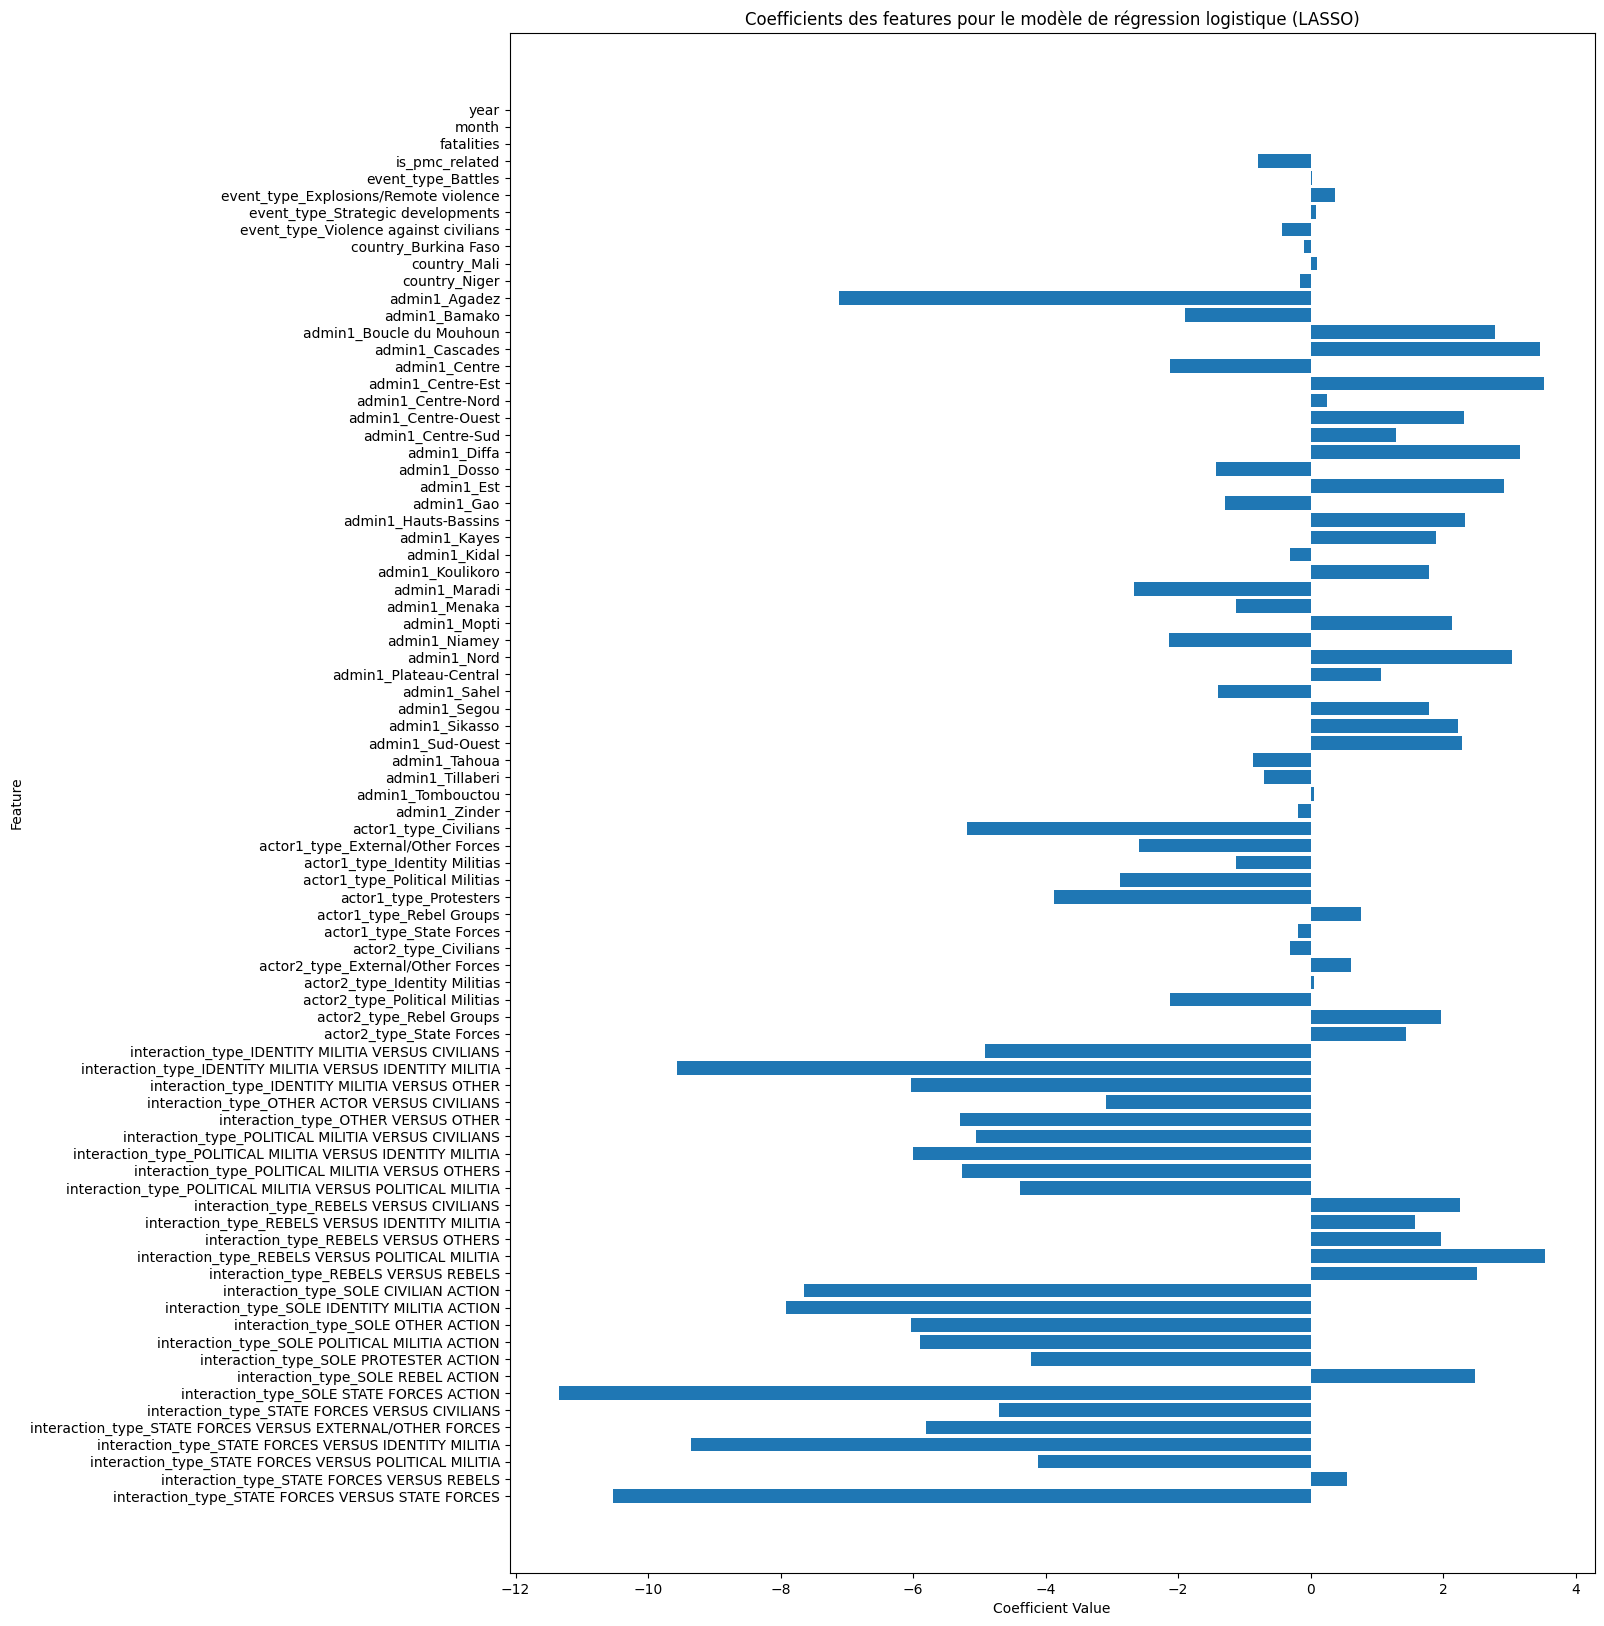


## RAPPORT DE CLASSIFICATION (LASSO)
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       754
           1       0.96      1.00      0.98      2057

    accuracy                           0.96      2811
   macro avg       0.97      0.94      0.95      2811
weighted avg       0.97      0.96      0.96      2811


## AUC-ROC
Score : 0.9825726090247573


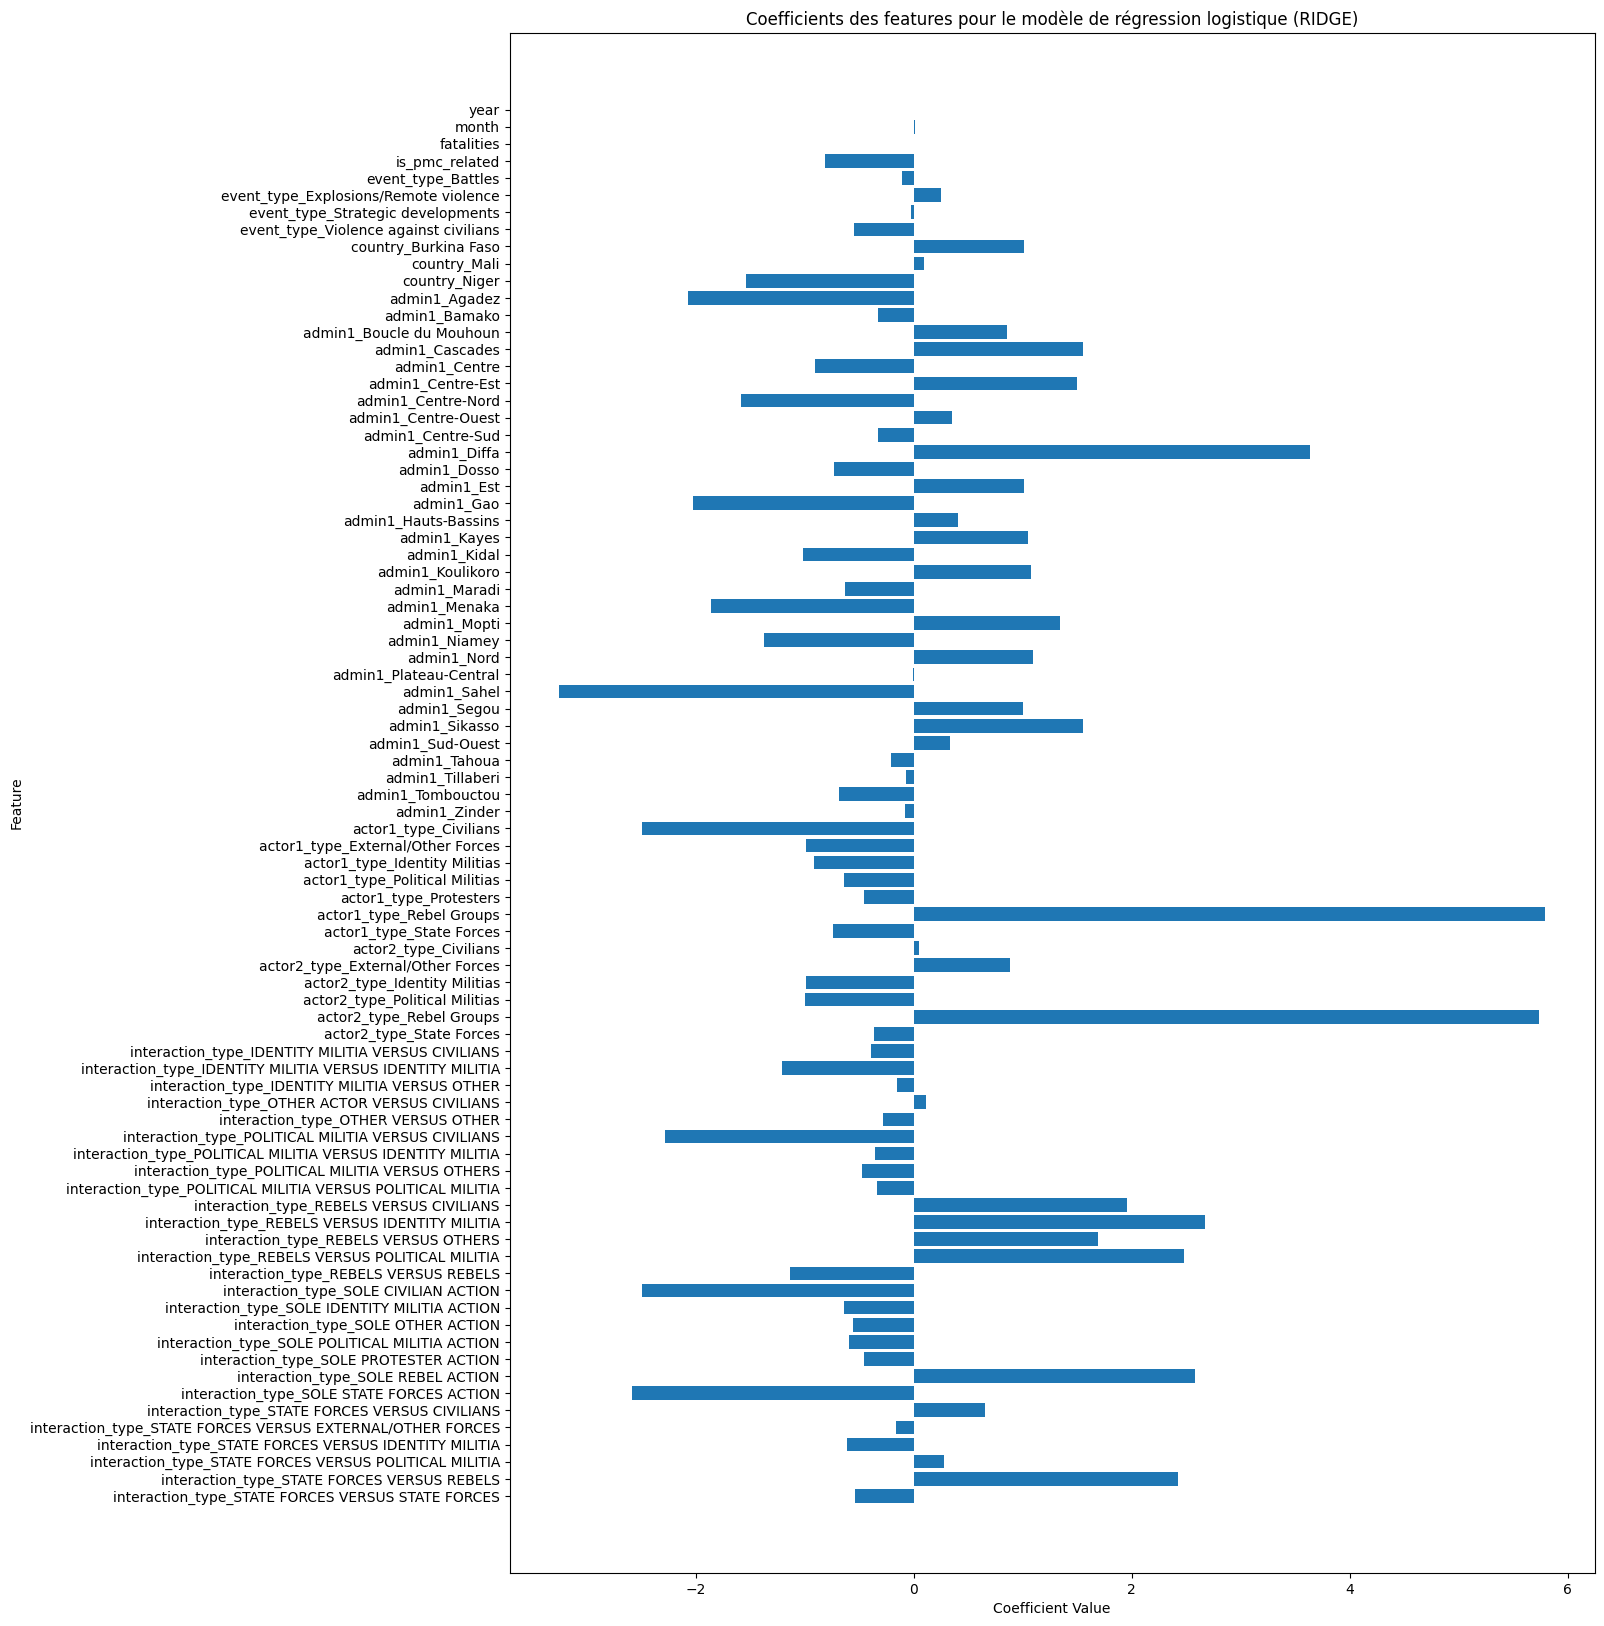


## RAPPORT DE CLASSIFICATION (RIDGE)
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       754
           1       0.96      1.00      0.98      2057

    accuracy                           0.96      2811
   macro avg       0.97      0.94      0.95      2811
weighted avg       0.97      0.96      0.96      2811


## AUC-ROC
Score : 0.9824559084654972


In [3]:
##
# On reprend notre étude de linéarité avec l'analyse des coefficients de la régression logistique
# afin d'évaluer si la relation entre les variables indépendantes et la variable cible est linéaire
coefficients = pd.DataFrame({"Feature":  X_train_encoded.columns, "Coefficient": logreg.coef_[0]})
# Visualisation des coefficients
plt.figure(figsize=(14, 20))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients des features pour le modèle de régression logistique')
plt.gca().invert_yaxis()
plt.show()
# Il semble y avoir une multicollinéarité entre les caractéristiques de notre modèle car on observe
# des valeurs élevées et d'autres assez faibles, la variance ne semble pas être stable.
# on peut essayer d'effectuer une régularisation comme la régression Ridge (L2) ou la régression Lasso (L1)
# pour pénaliser les coefficients et réduire la variance.

# Régularisation avec pénalisation L1 pour la sélection automatique de fonctionnalités
# en mettant à zéro les coefficients des caractéristiques les moins importantes
from sklearn.model_selection import GridSearchCV

# C contrôle la force de la pénalité, plus il est grand, plus la pénalité est forte
# On va tester différentes valeur afin de trouver le C optimal
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# On initialise un modèle de régression logistique avec une pénalité Lasso
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# On effectue la recherche de l'hyperparamètre C
grid_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_encoded, y_train)

# On entraine le modèle avec le meilleur hyperparamètre
best_lasso_model = grid_search.best_estimator_
best_lasso_model.fit(X_train_encoded, y_train)

# Prédictions
lasso_pred = best_lasso_model.predict(X_test_encoded)
lasso_pred_prob = best_lasso_model.predict_proba(X_test_encoded)[:, 1]

# On récupère les coefficients après pénalisation L1
coefficients_lasso = pd.DataFrame({"Feature":  X_train_encoded.columns, "Coefficient": best_lasso_model.coef_[0]})
# Visualisation des coefficients
plt.figure(figsize=(14, 20))
plt.barh(coefficients_lasso['Feature'], coefficients_lasso['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients des features pour le modèle de régression logistique (LASSO)')
plt.gca().invert_yaxis()
plt.show()

# On affiche les performances du modfèle avec Lasso
print("\n## RAPPORT DE CLASSIFICATION (LASSO)")
print(classification_report(y_test, lasso_pred))
print("\n## AUC-ROC")
print("Score :", roc_auc_score(y_test, lasso_pred_prob))


# Régularisation avec pénalisation L2 pour contrôler le surajustement et améliorer
# la généralisation en ajoutant une pénalité sur la norme L2 des coefficients
# On initialise un modèle de régression logistique avec une pénalité Ridge
ridge_model = lasso_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)

# On effectue la recherche de l'hyperparamètre C
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_encoded, y_train)

# On entraine le modèle avec le meilleur hyperparamètre
best_ridge_model = grid_search.best_estimator_
best_ridge_model.fit(X_train_encoded, y_train)

# Prédictions
ridge_pred = best_ridge_model.predict(X_test_encoded)
ridge_pred_prob = best_ridge_model.predict_proba(X_test_encoded)[:, 1]

# On récupère les coefficients après pénalisation L2
coefficients_ridge = pd.DataFrame({"Feature":  X_train_encoded.columns, "Coefficient": best_ridge_model.coef_[0]})
# Visualisation des coefficients
plt.figure(figsize=(14, 20))
plt.barh(coefficients_ridge['Feature'], coefficients_ridge['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients des features pour le modèle de régression logistique (RIDGE)')
plt.gca().invert_yaxis()
plt.show()

# On affiche les performances du modèle avec Ridge
print("\n## RAPPORT DE CLASSIFICATION (RIDGE)")
print(classification_report(y_test, ridge_pred))
print("\n## AUC-ROC")
print("Score :", roc_auc_score(y_test, ridge_pred_prob))



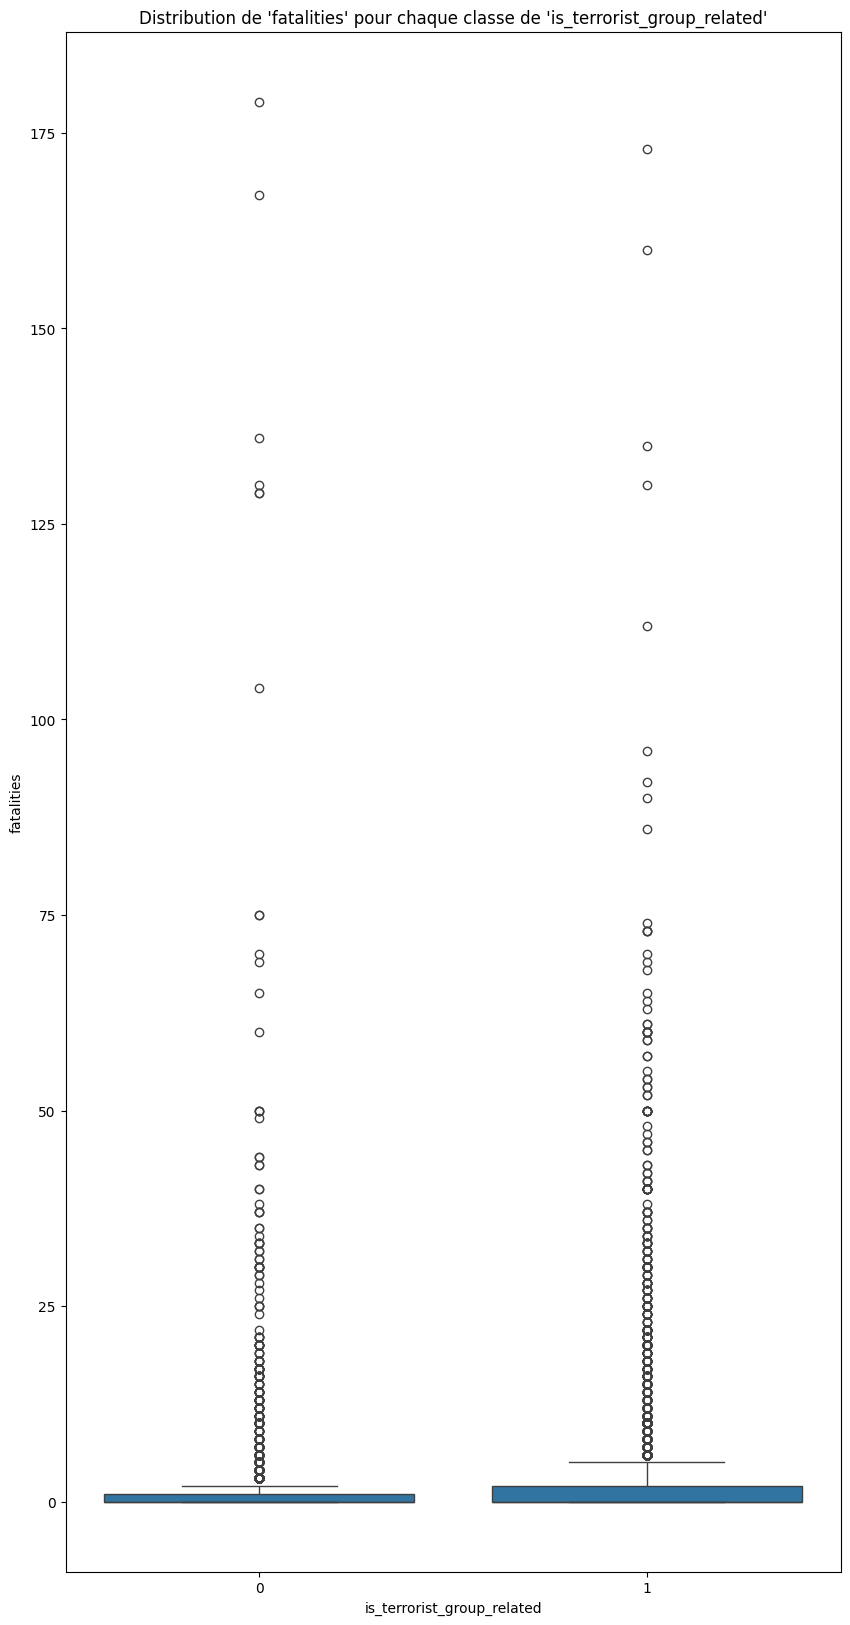

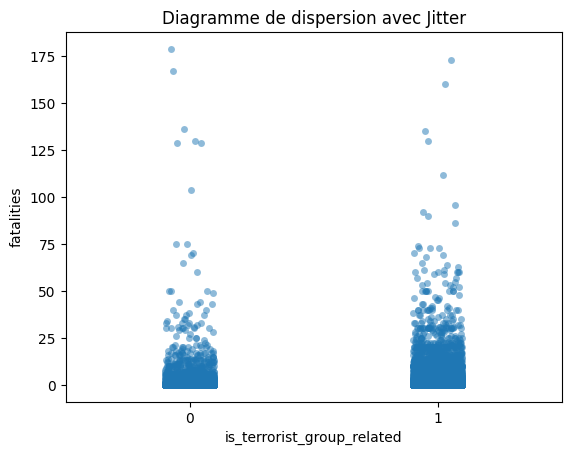

In [4]:
##
# Pour la variable continue "fatalities", on crée des visualisations pour examiner les relations
# de linéarité avec la variable cible

# D'abord grâce à un box plot on visualise la distribution de fatalities
# pour chaque classe de la variable cible
plt.figure(figsize=(10, 20))
sns.boxplot(x=y, y=X['fatalities'])
plt.title("Distribution de 'fatalities' pour chaque classe de 'is_terrorist_group_related'")
plt.show()
# On remarque qu'il y a pas mal de valeurs extrêmes, et que la distribution n'est pas homogène,
# ce qui indique une non-linéarité.

# Ensuite avec un scatter plot on veut examiner la relation entre "fatalities" et la variable cible
# On ajoute du jitter pour éviter que les points ne se chevauchent lorsqu'ils ont la même valeur
sns.stripplot(x=y, y=X['fatalities'], jitter=True, alpha=0.5)
plt.title('Diagramme de dispersion avec Jitter')
plt.show()
# On observe que les données sont dispersées autour d'un axe vertical pour chaque classe (0 et 1), cela suggère donc
# une absence de relation linéaire entre la variable continue "fatalities" et la variable cible.

## CONCLUSION DE L'ETUDE DE LINEARITE
# Notre modèle de régression logistique n'est pas linéaire et notre feature continue également. On peut donc choisir :
# - d'entrainer un modèle non-linéaire (random forest, xgboost)
# - d'effectuer une réduction de dimension afin d'identifier les variables les plus importantes
#   ou les plus discriminantes dans les données, mais également pour aider à réduire le risque de surajustement.

